# Mini-lab 7: Neural logistic regression

You will find code for generating three toy data sets and a neural logistic regression model to perform classifdication with. Your task is to extend the neural model to:

1. change the learning rate, compare loss/accuracy curves
2. multiclass classification for a predefined number of classes
3. allow for more complex decision boundaries (hint: read up on nn.Sigmoid and nn.Linear, a more complex network might need more time to train)

It might be beneficial to add model parameters for some of the above functionalities (e.g., n_outputs, learning_rate).

As usual, we stand with some imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Choose your data

In [2]:
from sklearn.datasets import make_classification, make_moons, make_blobs

# Load the toy data
X, y = make_blobs(n_samples=200, centers=2, cluster_std=.7, n_features=2, random_state=0)
# X, y = make_moons(n_samples=200, noise=.1, random_state=0)
# X, y = make_classification(n_samples=200, n_features=2, n_informative=2, 
#                            n_redundant=0, n_repeated=0, n_classes=3, class_sep=1.8,
#                            n_clusters_per_class=1, random_state=0)

It's nice to have a plotting function. This will show us the data but also visualise the model predictions.

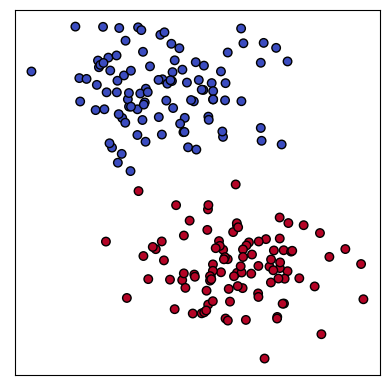

In [3]:
def plot_classification(model=None):
  fig = plt.figure(figsize=(4, 4), dpi=100)
  ax = fig.subplots(1, 1)
  ax.scatter(X[:, 0], X[:, 1], c=y, s=150, marker='.', edgecolor='k', cmap='coolwarm')
  if model is not None:
    a = ax.axis()
    XX, YY = np.meshgrid(np.linspace(a[0], a[1], 200),
                        np.linspace(a[2], a[3], 200))
    X_test = torch.Tensor(np.concatenate([np.vstack(XX.ravel()), 
                                          np.vstack(YY.ravel())], axis=1))
    Z = model.predict(X_test)
    ax.pcolor(XX, YY, Z.reshape(XX.shape), alpha=.5, cmap='coolwarm', edgecolors='none', snap=True, zorder=-1)
  ax.set_xticks([])
  ax.set_yticks([])
  fig.tight_layout()
  fig.show()

plot_classification()

Now for defining the model. It is probably best if you start with running the model and then try to understand its inner working by reading the manual and adding small pieces of functionality. Note that this is written to comply with the sklearn estimator format and is far from a minimalist implementation.

In [4]:
import torch
import torch.nn as nn

class LogisticRegression(nn.Module):
  def __init__(self, n_iter=20, verbose=False):
    """Simple classifier for 2D data
    
    This is based on logistic regressing but the output is a softmax."""
    super(LogisticRegression, self).__init__()
    self.n_iter = n_iter
    assert n_iter > 0
    self.verbose = verbose
    # torch.manual_seed(0) # Forces the same initial weights every time
    # Define layers
    self.net = nn.Sequential(   # Container for sequential operations
            nn.Linear(2, 2),
            nn.Softmax(dim=1))
    # Define optimiser and loss
    self.optimizer_ = torch.optim.SGD(self.parameters(), lr=1)
    self.loss_function_ = nn.CrossEntropyLoss()
    # For making nice plots
    self.training_loss_ = list()
    self.training_accuracy_ = list()

  def forward(self, X):
    """Forward pass, this is used for making predictions."""
    return self.net(X)

  def _reset(self):
    """Reset the model weights."""
    # There has to be a simpler way to do this
    for _, module in model.named_children():
      if hasattr(module, 'reset_parameters'):
        module.reset_parameters()
      if hasattr(module, 'named_children'):
        for _, submodule in module.named_children():
          if hasattr(submodule, 'reset_parameters'):
            submodule.reset_parameters()
  
  def fit(self, X, y):
    """Train the model"""
    self._reset()
    for epoch in range(self.n_iter):
      self._fit(X, y)
      if self.verbose:
        if self.n_iter < 50 or (epoch % 50) == 0:
          print("Epoch %2i: Loss %.7f" % (epoch, self._loss.item()))

  def _fit(self, X, y):
    """A single step in the training"""
    self.zero_grad()              # Reset gradients
    forward_pass_output = self(X) # Forward pass
    self._loss = self.loss_function_(forward_pass_output, y) # Calculate loss
    self._loss.backward()         # Backward pass
    self.optimizer_.step()        # Run the optimizer one step
    # Store values for user feedback
    self.training_loss_.append(self._loss.item())
    self.training_accuracy_.append(self.score(X, y))

  def predict(self, X):
    """Predict labels"""
    return np.argmax(self.predict_proba(X), axis=1) # Pick max probabilities

  def predict_proba(self, X):
    """Predict label probabilities"""
    with torch.no_grad():         # Disable gradient calculations
      log_probs = self(X)         # Forward pass to predict probabilities
    return log_probs.detach().numpy()

  def score(self, X, y):
    """Get the accuracy of the model given the data"""
    return np.sum(self.predict(X)==y.numpy())/len(y)

model = LogisticRegression(n_iter=5000)
print(model)

# Convert the data to torch tensors
X = torch.Tensor(X)
y = torch.LongTensor(y)

LogisticRegression(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Softmax(dim=1)
  )
  (loss_function_): CrossEntropyLoss()
)


The model starts out with random value as weights. This should give us a crappy classification.

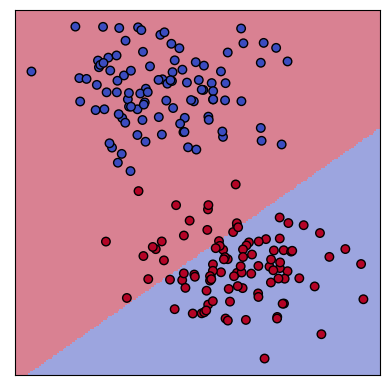

In [5]:
plot_classification(model)

Time for training. Note how the output here changes 

In [6]:
model.fit(X, y)

print("Model training accuracy %.1f%%" % (100*model.score(X, y)))

Model training accuracy 100.0%


We can ask the model to tell us about its parameters.

In [7]:
for param in model.parameters():
  print(param)

Parameter containing:
tensor([[-0.7616,  2.7171],
        [ 0.7264, -2.9949]], requires_grad=True)
Parameter containing:
tensor([-6.4840,  6.4541], requires_grad=True)


Remember the stored loss and accuracy values. We can plot these too.

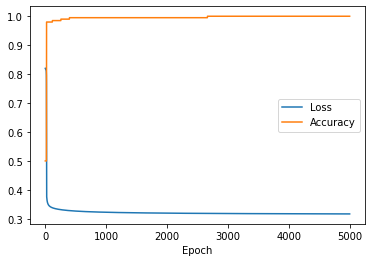

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(model.training_loss_, '-', label="Loss")
plt.plot(model.training_accuracy_, '-', label="Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

The classification should work better after training.

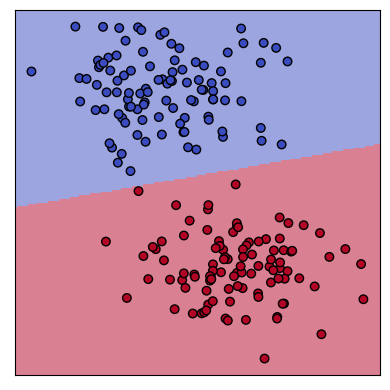

In [9]:
plot_classification(model)